# Notebook for DeBERTa-v3-base

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [90]:
from conllu import TokenList
import polars as pl
from stanza.models.common.doc import Token
from label_legends.preprocess import create_conllu, holdout, load_conllu, load_data, load_train, load_test, transform, load_vectorizer, reverse_vocabulary, vocabulary, ids_to_tokens, tokens_to_ids, vectorize_tokens, strip_stopwords
import logging
import mlflow
from mlflow import MlflowClient
from label_legends.result import calculate_scores, download_predictions, get_experiment, load_predictions, client, get_current
import json
import torch
from torch.utils.data import Dataset
import time
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoConfig, DebertaV2Tokenizer, Trainer, TrainingArguments


logging.basicConfig(level=logging.INFO)

## Training the model

In [91]:
MODEL_NAME = 'microsoft/deberta-v3-base'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer =DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
load_data().collect()

id,rewire_id,text,annotator,label_sexist,label_category,label_vector,split,tokens
i64,str,str,i64,str,str,str,str,list[str]
0,"""sexism2022_english-0""",""" I wonder what keeps that witc…",17,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
1,"""sexism2022_english-0""",""" I wonder what keeps that witc…",2,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
10,"""sexism2022_english-100""","""Good for her! My grandson had …",3,"""not sexist""","""none""","""none""","""train""","[""good"", ""for"", … ""!""]"
100,"""sexism2022_english-10026""","""It is not insulting, it's **ex…",14,"""sexist""","""2. derogation""","""2.1 descriptive attacks""","""test""","[""it"", ""be"", … "".**""]"
1000,"""sexism2022_english-10297""","""The article said Madonna offer…",5,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""train""","[""the"", ""article"", … "".""]"
…,…,…,…,…,…,…,…,…
9995,"""sexism2022_english-12996""","""Shudder.. if you had to have s…",17,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""test""","[""shudder"", "".."", … "".""]"
9996,"""sexism2022_english-12997""","""You mean one that forces women…",6,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"
9997,"""sexism2022_english-12997""","""You mean one that forces women…",4,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"


### Splitting the dataset to training validation test

In [93]:
val, tra = holdout()
tra = transform(tra)
val = transform(val)

train_texts = tra["text"].to_list()
train_labels = tra["label"].to_list()
val_texts = val["text"].to_list()
val_labels = val["label"].to_list()

test = transform(load_test().collect())
test_texts = test["text"].to_list()
test_labels = test["label"].to_list()


### Tokenizing the splits

In [94]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,  
    return_tensors="pt",
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)


In [95]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Creating the final datasets

In [96]:
train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)
test_dataset = SexistDataset(test_encodings, test_labels)

### Training parameters set

In [97]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    evaluation_strategy="epoch", 
    logging_steps=100,  
    save_strategy="epoch", 
    load_best_model_at_end=True, 
    metric_for_best_model='eval_loss', 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)


/Users/retipeter/Documents/TU Wien/NLP/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2812231330.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Running the model

In [98]:

start_time = time.time()
train_output = trainer.train()  
training_time_manual = time.time() - start_time #calculating training time manually
train_metrics = train_output.metrics  # Contains train_runtime, train_loss, etc.
print(f"Train time: {training_time_manual}")
print(f"Train Metrics: {train_metrics}")

  0%|          | 0/11025 [00:00<?, ?it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  1%|          | 100/11025 [00:38<1:08:36,  2.65it/s]

{'loss': 0.5764, 'grad_norm': 2.0835654735565186, 'learning_rate': 1.981859410430839e-05, 'epoch': 0.03}


  2%|▏         | 200/11025 [01:16<1:06:26,  2.72it/s]

{'loss': 0.5265, 'grad_norm': 8.028223037719727, 'learning_rate': 1.963718820861678e-05, 'epoch': 0.05}


  3%|▎         | 300/11025 [01:54<1:09:07,  2.59it/s]

{'loss': 0.5031, 'grad_norm': 9.859118461608887, 'learning_rate': 1.945578231292517e-05, 'epoch': 0.08}


  4%|▎         | 400/11025 [02:31<1:05:53,  2.69it/s]

{'loss': 0.4642, 'grad_norm': 1.9171615839004517, 'learning_rate': 1.9274376417233563e-05, 'epoch': 0.11}


  5%|▍         | 500/11025 [03:09<1:06:00,  2.66it/s]

{'loss': 0.4161, 'grad_norm': 15.203277587890625, 'learning_rate': 1.9092970521541953e-05, 'epoch': 0.14}


  5%|▌         | 600/11025 [03:45<1:02:52,  2.76it/s]

{'loss': 0.4222, 'grad_norm': 10.431306838989258, 'learning_rate': 1.8911564625850343e-05, 'epoch': 0.16}


  6%|▋         | 700/11025 [04:23<1:05:09,  2.64it/s]

{'loss': 0.4518, 'grad_norm': 4.238683223724365, 'learning_rate': 1.8730158730158732e-05, 'epoch': 0.19}


  7%|▋         | 800/11025 [05:00<1:02:36,  2.72it/s]

{'loss': 0.417, 'grad_norm': 17.732154846191406, 'learning_rate': 1.8548752834467122e-05, 'epoch': 0.22}


  8%|▊         | 900/11025 [05:37<1:03:00,  2.68it/s]

{'loss': 0.4057, 'grad_norm': 6.413863182067871, 'learning_rate': 1.836734693877551e-05, 'epoch': 0.24}


  9%|▉         | 1000/11025 [06:15<1:02:08,  2.69it/s]

{'loss': 0.4036, 'grad_norm': 4.023458957672119, 'learning_rate': 1.81859410430839e-05, 'epoch': 0.27}


 10%|▉         | 1100/11025 [06:53<1:01:27,  2.69it/s]

{'loss': 0.4299, 'grad_norm': 4.905649662017822, 'learning_rate': 1.8004535147392294e-05, 'epoch': 0.3}


 11%|█         | 1200/11025 [07:30<1:00:51,  2.69it/s]

{'loss': 0.3901, 'grad_norm': 1.4741846323013306, 'learning_rate': 1.782312925170068e-05, 'epoch': 0.33}


 12%|█▏        | 1300/11025 [08:07<1:00:04,  2.70it/s]

{'loss': 0.3942, 'grad_norm': 7.662624835968018, 'learning_rate': 1.7641723356009073e-05, 'epoch': 0.35}


 13%|█▎        | 1400/11025 [08:45<59:49,  2.68it/s]  

{'loss': 0.3978, 'grad_norm': 5.8093647956848145, 'learning_rate': 1.7460317460317463e-05, 'epoch': 0.38}


 14%|█▎        | 1500/11025 [09:22<58:54,  2.69it/s]  

{'loss': 0.3834, 'grad_norm': 3.055901050567627, 'learning_rate': 1.7278911564625852e-05, 'epoch': 0.41}


 15%|█▍        | 1600/11025 [09:59<58:32,  2.68it/s]

{'loss': 0.399, 'grad_norm': 8.883439064025879, 'learning_rate': 1.7097505668934242e-05, 'epoch': 0.44}


 15%|█▌        | 1700/11025 [10:36<59:07,  2.63it/s]  

{'loss': 0.4317, 'grad_norm': 7.321454048156738, 'learning_rate': 1.691609977324263e-05, 'epoch': 0.46}


 16%|█▋        | 1800/11025 [11:14<57:47,  2.66it/s]  

{'loss': 0.3845, 'grad_norm': 5.168199062347412, 'learning_rate': 1.673469387755102e-05, 'epoch': 0.49}


 17%|█▋        | 1900/11025 [11:52<58:27,  2.60it/s]  

{'loss': 0.3749, 'grad_norm': 5.247435092926025, 'learning_rate': 1.655328798185941e-05, 'epoch': 0.52}


 18%|█▊        | 2000/11025 [12:30<56:06,  2.68it/s]  

{'loss': 0.3752, 'grad_norm': 14.192232131958008, 'learning_rate': 1.63718820861678e-05, 'epoch': 0.54}


 19%|█▉        | 2100/11025 [13:08<55:12,  2.69it/s]

{'loss': 0.3651, 'grad_norm': 3.737636089324951, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}


 20%|█▉        | 2200/11025 [13:45<55:10,  2.67it/s]

{'loss': 0.3807, 'grad_norm': 3.5279922485351562, 'learning_rate': 1.6009070294784583e-05, 'epoch': 0.6}


 21%|██        | 2300/11025 [14:22<54:09,  2.68it/s]

{'loss': 0.4251, 'grad_norm': 12.040055274963379, 'learning_rate': 1.5827664399092972e-05, 'epoch': 0.63}


 22%|██▏       | 2400/11025 [15:00<53:28,  2.69it/s]

{'loss': 0.3997, 'grad_norm': 7.4524617195129395, 'learning_rate': 1.5646258503401362e-05, 'epoch': 0.65}


 23%|██▎       | 2500/11025 [15:37<52:48,  2.69it/s]

{'loss': 0.3574, 'grad_norm': 9.666398048400879, 'learning_rate': 1.546485260770975e-05, 'epoch': 0.68}


 24%|██▎       | 2600/11025 [16:14<52:09,  2.69it/s]

{'loss': 0.4099, 'grad_norm': 7.061330318450928, 'learning_rate': 1.528344671201814e-05, 'epoch': 0.71}


 24%|██▍       | 2700/11025 [16:52<51:53,  2.67it/s]

{'loss': 0.3716, 'grad_norm': 3.5628724098205566, 'learning_rate': 1.510204081632653e-05, 'epoch': 0.73}


 25%|██▌       | 2800/11025 [17:32<51:05,  2.68it/s]  

{'loss': 0.3666, 'grad_norm': 4.259285926818848, 'learning_rate': 1.4920634920634922e-05, 'epoch': 0.76}


 26%|██▋       | 2900/11025 [18:10<49:58,  2.71it/s]  

{'loss': 0.3818, 'grad_norm': 4.207743167877197, 'learning_rate': 1.4739229024943311e-05, 'epoch': 0.79}


 27%|██▋       | 3000/11025 [18:48<49:45,  2.69it/s]

{'loss': 0.3681, 'grad_norm': 7.096469402313232, 'learning_rate': 1.4557823129251703e-05, 'epoch': 0.82}


 28%|██▊       | 3100/11025 [19:25<48:58,  2.70it/s]

{'loss': 0.3656, 'grad_norm': 1.336202621459961, 'learning_rate': 1.4376417233560092e-05, 'epoch': 0.84}


 29%|██▉       | 3200/11025 [20:02<48:07,  2.71it/s]

{'loss': 0.3208, 'grad_norm': 4.036442279815674, 'learning_rate': 1.4195011337868484e-05, 'epoch': 0.87}


 30%|██▉       | 3300/11025 [20:39<47:37,  2.70it/s]

{'loss': 0.3803, 'grad_norm': 5.149099349975586, 'learning_rate': 1.4013605442176872e-05, 'epoch': 0.9}


 31%|███       | 3400/11025 [21:16<46:53,  2.71it/s]

{'loss': 0.4171, 'grad_norm': 2.8452911376953125, 'learning_rate': 1.3832199546485261e-05, 'epoch': 0.93}


 32%|███▏      | 3500/11025 [21:53<46:16,  2.71it/s]

{'loss': 0.3251, 'grad_norm': 1.304904580116272, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 3600/11025 [22:30<45:43,  2.71it/s]

{'loss': 0.4171, 'grad_norm': 6.169004440307617, 'learning_rate': 1.3469387755102042e-05, 'epoch': 0.98}


                                                    
 33%|███▎      | 3675/11025 [25:16<45:29,  2.69it/s]

{'eval_loss': 0.3288102149963379, 'eval_runtime': 138.1317, 'eval_samples_per_second': 91.217, 'eval_steps_per_second': 11.402, 'epoch': 1.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 34%|███▎      | 3700/11025 [25:27<45:19,  2.69it/s]   

{'loss': 0.3906, 'grad_norm': 2.726330041885376, 'learning_rate': 1.3287981859410433e-05, 'epoch': 1.01}


 34%|███▍      | 3800/11025 [26:04<45:00,  2.68it/s]

{'loss': 0.3138, 'grad_norm': 7.502457618713379, 'learning_rate': 1.3106575963718821e-05, 'epoch': 1.03}


 35%|███▌      | 3900/11025 [26:41<44:11,  2.69it/s]

{'loss': 0.2988, 'grad_norm': 13.665358543395996, 'learning_rate': 1.2925170068027212e-05, 'epoch': 1.06}


 36%|███▋      | 4000/11025 [27:19<43:21,  2.70it/s]

{'loss': 0.3075, 'grad_norm': 4.962534427642822, 'learning_rate': 1.2743764172335602e-05, 'epoch': 1.09}


 37%|███▋      | 4100/11025 [27:56<42:46,  2.70it/s]

{'loss': 0.355, 'grad_norm': 3.716488838195801, 'learning_rate': 1.2562358276643992e-05, 'epoch': 1.12}


 38%|███▊      | 4200/11025 [28:33<42:18,  2.69it/s]

{'loss': 0.3113, 'grad_norm': 31.872554779052734, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}


 39%|███▉      | 4300/11025 [29:10<41:24,  2.71it/s]

{'loss': 0.3145, 'grad_norm': 12.17998218536377, 'learning_rate': 1.219954648526077e-05, 'epoch': 1.17}


 40%|███▉      | 4400/11025 [29:47<41:17,  2.67it/s]

{'loss': 0.3176, 'grad_norm': 12.016297340393066, 'learning_rate': 1.2018140589569162e-05, 'epoch': 1.2}


 41%|████      | 4500/11025 [30:24<40:11,  2.71it/s]

{'loss': 0.2651, 'grad_norm': 7.964865684509277, 'learning_rate': 1.1836734693877552e-05, 'epoch': 1.22}


 42%|████▏     | 4600/11025 [31:01<39:32,  2.71it/s]

{'loss': 0.3528, 'grad_norm': 10.10000228881836, 'learning_rate': 1.1655328798185943e-05, 'epoch': 1.25}


 43%|████▎     | 4700/11025 [31:39<39:36,  2.66it/s]

{'loss': 0.3171, 'grad_norm': 7.953835487365723, 'learning_rate': 1.1473922902494332e-05, 'epoch': 1.28}


 44%|████▎     | 4800/11025 [32:16<39:06,  2.65it/s]

{'loss': 0.3573, 'grad_norm': 11.227317810058594, 'learning_rate': 1.1292517006802722e-05, 'epoch': 1.31}


 44%|████▍     | 4900/11025 [32:54<38:42,  2.64it/s]

{'loss': 0.3061, 'grad_norm': 4.870126724243164, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}


 45%|████▌     | 5000/11025 [33:32<37:09,  2.70it/s]

{'loss': 0.3369, 'grad_norm': 9.731133460998535, 'learning_rate': 1.0929705215419501e-05, 'epoch': 1.36}


 46%|████▋     | 5100/11025 [34:10<37:54,  2.61it/s]

{'loss': 0.3358, 'grad_norm': 9.1620454788208, 'learning_rate': 1.0748299319727893e-05, 'epoch': 1.39}


 47%|████▋     | 5200/11025 [34:49<36:54,  2.63it/s]

{'loss': 0.2941, 'grad_norm': 18.010732650756836, 'learning_rate': 1.0566893424036282e-05, 'epoch': 1.41}


 48%|████▊     | 5300/11025 [35:27<35:18,  2.70it/s]

{'loss': 0.376, 'grad_norm': 0.5778183937072754, 'learning_rate': 1.0385487528344672e-05, 'epoch': 1.44}


 49%|████▉     | 5400/11025 [36:05<34:51,  2.69it/s]

{'loss': 0.2732, 'grad_norm': 10.099592208862305, 'learning_rate': 1.0204081632653063e-05, 'epoch': 1.47}


 50%|████▉     | 5500/11025 [36:43<35:03,  2.63it/s]

{'loss': 0.3288, 'grad_norm': 17.639060974121094, 'learning_rate': 1.0022675736961451e-05, 'epoch': 1.5}


 51%|█████     | 5600/11025 [37:20<34:10,  2.65it/s]

{'loss': 0.3292, 'grad_norm': 4.405653953552246, 'learning_rate': 9.841269841269842e-06, 'epoch': 1.52}


 52%|█████▏    | 5700/11025 [37:58<33:24,  2.66it/s]

{'loss': 0.3252, 'grad_norm': 8.086126327514648, 'learning_rate': 9.659863945578232e-06, 'epoch': 1.55}


 53%|█████▎    | 5800/11025 [38:37<33:09,  2.63it/s]

{'loss': 0.2918, 'grad_norm': 5.71996545791626, 'learning_rate': 9.478458049886621e-06, 'epoch': 1.58}


 54%|█████▎    | 5900/11025 [39:15<32:03,  2.66it/s]

{'loss': 0.3361, 'grad_norm': 2.199155807495117, 'learning_rate': 9.297052154195013e-06, 'epoch': 1.61}


 54%|█████▍    | 6000/11025 [39:53<31:59,  2.62it/s]

{'loss': 0.3278, 'grad_norm': 6.188827991485596, 'learning_rate': 9.115646258503402e-06, 'epoch': 1.63}


 55%|█████▌    | 6100/11025 [40:31<32:37,  2.52it/s]

{'loss': 0.3067, 'grad_norm': 3.875086545944214, 'learning_rate': 8.934240362811792e-06, 'epoch': 1.66}


 56%|█████▌    | 6200/11025 [41:10<30:34,  2.63it/s]

{'loss': 0.3257, 'grad_norm': 12.854330062866211, 'learning_rate': 8.752834467120183e-06, 'epoch': 1.69}


 57%|█████▋    | 6300/11025 [41:49<29:29,  2.67it/s]

{'loss': 0.3237, 'grad_norm': 4.5853271484375, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}


 58%|█████▊    | 6400/11025 [42:26<29:41,  2.60it/s]

{'loss': 0.3145, 'grad_norm': 10.376612663269043, 'learning_rate': 8.390022675736962e-06, 'epoch': 1.74}


 59%|█████▉    | 6500/11025 [43:05<29:36,  2.55it/s]

{'loss': 0.2963, 'grad_norm': 0.7873433232307434, 'learning_rate': 8.208616780045352e-06, 'epoch': 1.77}


 60%|█████▉    | 6600/11025 [43:45<28:52,  2.55it/s]

{'loss': 0.3011, 'grad_norm': 11.326220512390137, 'learning_rate': 8.027210884353741e-06, 'epoch': 1.8}


 61%|██████    | 6700/11025 [44:24<27:40,  2.60it/s]

{'loss': 0.3329, 'grad_norm': 5.492082595825195, 'learning_rate': 7.845804988662133e-06, 'epoch': 1.82}


 62%|██████▏   | 6800/11025 [45:03<27:35,  2.55it/s]

{'loss': 0.3208, 'grad_norm': 10.484877586364746, 'learning_rate': 7.664399092970522e-06, 'epoch': 1.85}


 63%|██████▎   | 6900/11025 [45:42<26:58,  2.55it/s]

{'loss': 0.3018, 'grad_norm': 0.7977584004402161, 'learning_rate': 7.482993197278913e-06, 'epoch': 1.88}


 63%|██████▎   | 7000/11025 [46:22<26:20,  2.55it/s]

{'loss': 0.3115, 'grad_norm': 8.072693824768066, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 64%|██████▍   | 7100/11025 [47:01<25:47,  2.54it/s]

{'loss': 0.3082, 'grad_norm': 1.0881154537200928, 'learning_rate': 7.120181405895692e-06, 'epoch': 1.93}


 65%|██████▌   | 7200/11025 [47:41<25:41,  2.48it/s]

{'loss': 0.3576, 'grad_norm': 8.373588562011719, 'learning_rate': 6.938775510204082e-06, 'epoch': 1.96}


 66%|██████▌   | 7300/11025 [48:20<25:07,  2.47it/s]

{'loss': 0.3226, 'grad_norm': 3.468111038208008, 'learning_rate': 6.757369614512473e-06, 'epoch': 1.99}


                                                    
 67%|██████▋   | 7350/11025 [51:02<24:25,  2.51it/s]

{'eval_loss': 0.38723477721214294, 'eval_runtime': 139.6539, 'eval_samples_per_second': 90.223, 'eval_steps_per_second': 11.278, 'epoch': 2.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 67%|██████▋   | 7400/11025 [51:24<23:23,  2.58it/s]   

{'loss': 0.3017, 'grad_norm': 0.7620372176170349, 'learning_rate': 6.575963718820862e-06, 'epoch': 2.01}


 68%|██████▊   | 7500/11025 [52:02<21:52,  2.69it/s]

{'loss': 0.2354, 'grad_norm': 0.12345786392688751, 'learning_rate': 6.394557823129253e-06, 'epoch': 2.04}


 69%|██████▉   | 7600/11025 [52:41<21:54,  2.61it/s]

{'loss': 0.2089, 'grad_norm': 2.5865910053253174, 'learning_rate': 6.2131519274376415e-06, 'epoch': 2.07}


 70%|██████▉   | 7700/11025 [53:19<21:09,  2.62it/s]

{'loss': 0.322, 'grad_norm': 1.5571696758270264, 'learning_rate': 6.031746031746032e-06, 'epoch': 2.1}


 71%|███████   | 7800/11025 [53:58<20:17,  2.65it/s]

{'loss': 0.2571, 'grad_norm': 14.015165328979492, 'learning_rate': 5.850340136054422e-06, 'epoch': 2.12}


 72%|███████▏  | 7900/11025 [54:36<19:43,  2.64it/s]

{'loss': 0.2719, 'grad_norm': 9.405807495117188, 'learning_rate': 5.668934240362812e-06, 'epoch': 2.15}


 73%|███████▎  | 8000/11025 [55:15<19:14,  2.62it/s]

{'loss': 0.2697, 'grad_norm': 16.815431594848633, 'learning_rate': 5.487528344671202e-06, 'epoch': 2.18}


 73%|███████▎  | 8100/11025 [55:53<18:35,  2.62it/s]

{'loss': 0.3024, 'grad_norm': 13.109796524047852, 'learning_rate': 5.306122448979593e-06, 'epoch': 2.2}


 74%|███████▍  | 8200/11025 [56:32<18:00,  2.62it/s]

{'loss': 0.2475, 'grad_norm': 7.588737964630127, 'learning_rate': 5.124716553287983e-06, 'epoch': 2.23}


 75%|███████▌  | 8300/11025 [57:10<17:07,  2.65it/s]

{'loss': 0.334, 'grad_norm': 7.395362377166748, 'learning_rate': 4.943310657596373e-06, 'epoch': 2.26}


 76%|███████▌  | 8400/11025 [57:48<16:34,  2.64it/s]

{'loss': 0.278, 'grad_norm': 0.5666347146034241, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}


 77%|███████▋  | 8500/11025 [58:26<16:00,  2.63it/s]

{'loss': 0.2717, 'grad_norm': 16.352190017700195, 'learning_rate': 4.580498866213152e-06, 'epoch': 2.31}


 78%|███████▊  | 8600/11025 [59:05<15:22,  2.63it/s]

{'loss': 0.3242, 'grad_norm': 0.25240209698677063, 'learning_rate': 4.399092970521542e-06, 'epoch': 2.34}


 79%|███████▉  | 8700/11025 [59:43<15:09,  2.56it/s]

{'loss': 0.2718, 'grad_norm': 0.47916367650032043, 'learning_rate': 4.217687074829933e-06, 'epoch': 2.37}


 80%|███████▉  | 8800/11025 [1:00:21<13:49,  2.68it/s]

{'loss': 0.3052, 'grad_norm': 8.761012077331543, 'learning_rate': 4.036281179138322e-06, 'epoch': 2.39}


 81%|████████  | 8900/11025 [1:00:59<13:08,  2.70it/s]

{'loss': 0.2335, 'grad_norm': 15.716368675231934, 'learning_rate': 3.854875283446712e-06, 'epoch': 2.42}


 82%|████████▏ | 9000/11025 [1:01:36<12:32,  2.69it/s]

{'loss': 0.2851, 'grad_norm': 8.429215431213379, 'learning_rate': 3.6734693877551024e-06, 'epoch': 2.45}


 83%|████████▎ | 9100/11025 [1:02:15<12:22,  2.59it/s]

{'loss': 0.2666, 'grad_norm': 7.176588535308838, 'learning_rate': 3.492063492063492e-06, 'epoch': 2.48}


 83%|████████▎ | 9200/11025 [1:02:53<11:37,  2.62it/s]

{'loss': 0.3671, 'grad_norm': 1.3219527006149292, 'learning_rate': 3.3106575963718824e-06, 'epoch': 2.5}


 84%|████████▍ | 9300/11025 [1:03:31<11:01,  2.61it/s]

{'loss': 0.2366, 'grad_norm': 0.8927417993545532, 'learning_rate': 3.1292517006802725e-06, 'epoch': 2.53}


 85%|████████▌ | 9400/11025 [1:04:10<10:07,  2.68it/s]

{'loss': 0.2866, 'grad_norm': 12.732004165649414, 'learning_rate': 2.947845804988662e-06, 'epoch': 2.56}


 86%|████████▌ | 9500/11025 [1:04:50<10:08,  2.50it/s]

{'loss': 0.2693, 'grad_norm': 0.7909669876098633, 'learning_rate': 2.7664399092970525e-06, 'epoch': 2.59}


 87%|████████▋ | 9600/11025 [1:05:29<09:03,  2.62it/s]

{'loss': 0.2809, 'grad_norm': 0.44463905692100525, 'learning_rate': 2.5850340136054425e-06, 'epoch': 2.61}


 88%|████████▊ | 9700/11025 [1:06:09<08:41,  2.54it/s]

{'loss': 0.3204, 'grad_norm': 0.9331309795379639, 'learning_rate': 2.4036281179138325e-06, 'epoch': 2.64}


 89%|████████▉ | 9800/11025 [1:06:47<07:31,  2.71it/s]

{'loss': 0.2878, 'grad_norm': 4.294024467468262, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}


 90%|████████▉ | 9900/11025 [1:07:24<06:59,  2.68it/s]

{'loss': 0.2753, 'grad_norm': 1.3706518411636353, 'learning_rate': 2.0408163265306125e-06, 'epoch': 2.69}


 91%|█████████ | 10000/11025 [1:08:03<06:38,  2.57it/s]

{'loss': 0.2583, 'grad_norm': 13.41502857208252, 'learning_rate': 1.8594104308390023e-06, 'epoch': 2.72}


 92%|█████████▏| 10100/11025 [1:08:43<06:11,  2.49it/s]

{'loss': 0.2377, 'grad_norm': 1.0877403020858765, 'learning_rate': 1.6780045351473925e-06, 'epoch': 2.75}


 93%|█████████▎| 10200/11025 [1:09:22<05:22,  2.56it/s]

{'loss': 0.3059, 'grad_norm': 21.091299057006836, 'learning_rate': 1.4965986394557825e-06, 'epoch': 2.78}


 93%|█████████▎| 10300/11025 [1:10:01<04:42,  2.57it/s]

{'loss': 0.2782, 'grad_norm': 1.0138745307922363, 'learning_rate': 1.3151927437641723e-06, 'epoch': 2.8}


 94%|█████████▍| 10400/11025 [1:10:40<04:05,  2.55it/s]

{'loss': 0.2665, 'grad_norm': 11.537872314453125, 'learning_rate': 1.1337868480725626e-06, 'epoch': 2.83}


 95%|█████████▌| 10500/11025 [1:11:20<03:24,  2.56it/s]

{'loss': 0.3062, 'grad_norm': 16.593326568603516, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


 96%|█████████▌| 10600/11025 [1:11:59<02:46,  2.55it/s]

{'loss': 0.2276, 'grad_norm': 16.737773895263672, 'learning_rate': 7.709750566893425e-07, 'epoch': 2.88}


 97%|█████████▋| 10700/11025 [1:12:38<02:07,  2.55it/s]

{'loss': 0.3292, 'grad_norm': 22.915475845336914, 'learning_rate': 5.895691609977325e-07, 'epoch': 2.91}


 98%|█████████▊| 10800/11025 [1:13:17<01:27,  2.56it/s]

{'loss': 0.247, 'grad_norm': 0.33412912487983704, 'learning_rate': 4.0816326530612243e-07, 'epoch': 2.94}


 99%|█████████▉| 10900/11025 [1:13:57<00:48,  2.55it/s]

{'loss': 0.3104, 'grad_norm': 0.5845579504966736, 'learning_rate': 2.267573696145125e-07, 'epoch': 2.97}


100%|█████████▉| 11000/11025 [1:14:36<00:09,  2.55it/s]

{'loss': 0.2806, 'grad_norm': 0.4855920672416687, 'learning_rate': 4.53514739229025e-08, 'epoch': 2.99}


100%|██████████| 11025/11025 [1:14:46<00:00,  2.53it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                                                       
100%|██████████| 11025/11025 [1:17:07<00:00,  2.53it/s]

{'eval_loss': 0.47502976655960083, 'eval_runtime': 139.1165, 'eval_samples_per_second': 90.572, 'eval_steps_per_second': 11.321, 'epoch': 3.0}


100%|██████████| 11025/11025 [1:17:10<00:00,  2.53it/s]

{'train_runtime': 4630.5515, 'train_samples_per_second': 19.047, 'train_steps_per_second': 2.381, 'train_loss': 0.33481114450225485, 'epoch': 3.0}


100%|██████████| 11025/11025 [1:17:11<00:00,  2.38it/s]

Train time: 4631.740176916122
Train Metrics: {'train_runtime': 4630.5515, 'train_samples_per_second': 19.047, 'train_steps_per_second': 2.381, 'total_flos': 4215299701989600.0, 'train_loss': 0.33481114450225485, 'epoch': 3.0}


## Fit the model to the validation set and predict

In [99]:
predicted = trainer.predict(val_dataset)

y_pred_val = np.argmax(predicted.predictions, axis=1) 
y_true_val = predicted.label_ids 

/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1575/1575 [02:26<00:00, 10.73it/s]


## Fit the model to the test set and predict

In [100]:
start_time_test = time.time()
predicted_test = trainer.predict(test_dataset)
test_time_manual = time.time() - start_time_test
print(f"Test time: {test_time_manual}")
test_metrics = predicted_test.metrics  # Contains train_runtime, train_loss, etc.
print(f"Test Metrics: {test_metrics}")

y_pred = np.argmax(predicted_test.predictions, axis=1)
y_true = predicted_test.label_ids



/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1500/1500 [02:22<00:00, 10.54it/s]

Test time: 142.45329785346985
Test Metrics: {'test_loss': 0.35058698058128357, 'test_runtime': 142.4494, 'test_samples_per_second': 84.24, 'test_steps_per_second': 10.53}


## Confusion Matrix

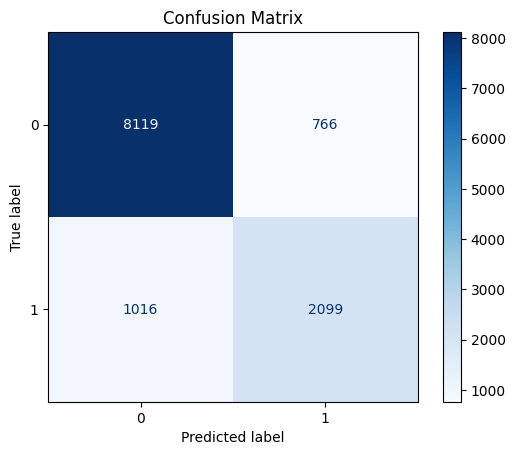

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

## New team standardized evaluation of the model

In [102]:
scores = calculate_scores(y_true, y_pred)
print(scores)

precision:	0.7326
recall:		0.6738
fscore:		0.7020
accuracy:	0.8515
tn: 8119	 fp: 766
fn: 1016	 tp: 2099


## New way of displaying the Confusion Matrix

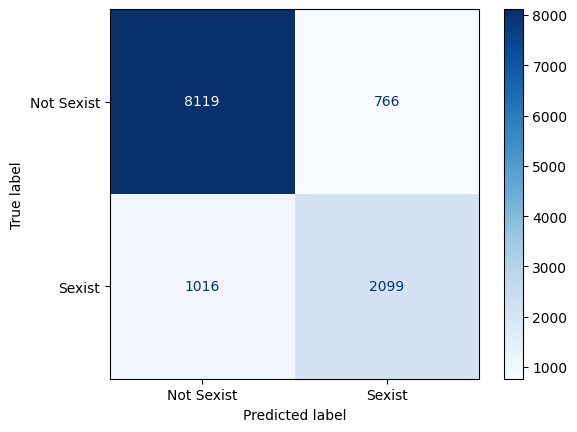

In [103]:
disp = ConfusionMatrixDisplay(confusion_matrix=scores.confusion_matrix(), display_labels=["Not Sexist", "Sexist"]).plot(cmap="Blues")

In [104]:
mlflow.end_run()

## Report model to MlFlow

In [105]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="DeBERTa-v3-base testing"
        ):
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("max_length", 128)
    mlflow.log_param("learning_rate", 5e-5)

    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "DeBERTa-v3")

    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions_DeBERTa.json")
    mlflow.log_figure(disp.figure_, "confusion_matrix.png")

    #log the model
    prediction_data = {
        "columns": ["id", "prediction"],
        "data": [[id_, pred.tolist()] for id_, pred in zip(test["id"], y_pred)]
    }
    #save to a JSON file
    predictions_file = r"../resource/mlflow/DeBERTa/predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(prediction_data, f, indent=4)
        
    #log the JSON file 
    mlflow.log_artifact(predictions_file)
        
    #simulate model registration
    mlflow.set_tag("registered_model_name", "DeBERTa-v3")
    mlflow.set_tag("model_alias", "current")

    #register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/predictions_DeBERTa.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="DeBERTa-v3") 


client().set_registered_model_alias("DeBERTa-v3", "current", registered_model.version)

Registered model 'DeBERTa-v3' already exists. Creating a new version of this model...
Created version '10' of model 'DeBERTa-v3'.


## Loading Predictions

In [106]:
get_current("DeBERTa-v3")

<ModelVersion: aliases=['current'], creation_timestamp=1734293954036, current_stage='None', description=None, last_updated_timestamp=1734293954036, name='DeBERTa-v3', run_id='5365d26e9b8344b48d2adbd02a5af427', run_link=None, source='file:///Users/retipeter/Documents/TU%20Wien/NLP/nlp-ie-label-legends/notebooks/mlruns/943899761474513424/5365d26e9b8344b48d2adbd02a5af427/artifacts/predictions_DeBERTa.json', status='READY', status_message=None, tags={}, user_id=None, version=10>

In [107]:
load_predictions("DeBERTa").head()

id,prediction
i64,i64
100,1
10005,0
10006,0
10007,0
10008,0


## *For me I got the logits of the model which need to be converted with sigmoid to get the probabilities of each class

In [108]:
#Kind of uneccessary but I thought I needed it for the final output.
#Didn't know how it worked so I investigated and found out that predicted_test.predictions are logits which need to be converted to get the probs of each class
placeholder = torch.tensor(predicted_test.predictions)
classes_predicted = torch.sigmoid(placeholder)
classes_predicted

tensor([[0.4151, 0.6027],
        [0.7112, 0.3068],
        [0.7112, 0.3068],
        ...,
        [0.4968, 0.5023],
        [0.4968, 0.5023],
        [0.4968, 0.5023]])